## VQG Fine-Tuning for Curiosity Question Generation

This notebook fine-tunes a Visual Question Generation (VQG) model to generate "WHY" questions similar to the annotated curiosity regions.

**Goal**: Fine-tune BLIP model to generate questions that match the style and type of questions in our annotations (primarily "WHY" questions about curious regions).

### Approach:
1. **Load all annotations** from Domain_1 through Domain_5 (200 images total)
2. **Crop images** to curiosity regions (bounding boxes) to focus the model on question-provoking areas
3. **Fine-tune BLIP** image-captioning model to generate questions instead of captions
4. **Train/Validate** split (80/20) with stratified sampling by question type
5. **Evaluate** on validation set and visualize results

### Model Architecture:
- **Base Model**: `Salesforce/blip-image-captioning-base`
- **Task**: Convert from image captioning to question generation
- **Input**: Cropped curiosity regions (bounding boxes)
- **Output**: Questions (primarily "WHY" questions)

# Install required packages
%pip install transformers torch torchvision pillow sentencepiece accelerate datasets scikit-learn


In [1]:
# Imports
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BlipProcessor, BlipForConditionalGeneration,
    TrainingArguments, Trainer, get_linear_schedule_with_warmup
)
from PIL import Image
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

print("Imports loaded")


c:\Users\tanma\Documents\VC_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports loaded


In [2]:
# Robust JSON loader (handles different encodings)
def load_json_any_encoding(path):
    """Load JSON file with multiple encoding attempts"""
    encodings = ['utf-8', 'utf-8-sig', 'utf-16', 'utf-16-le', 'utf-16-be',
                 'utf-32', 'utf-32-le', 'utf-32-be', 'cp1252', 'latin1']
    raw = Path(path).read_bytes()
    for enc in encodings:
        try:
            return json.loads(raw.decode(enc))
        except Exception:
            continue
    raise ValueError(f'Failed to decode JSON: {path}')

# Load all annotations from all domains
def load_all_annotations():
    """Load all annotations from Domain_1 through Domain_5"""
    all_data = []
    domains = [f"Domain_{i}_Images" for i in range(1, 6)]
    
    for domain_dir in domains:
        ann_path = Path(domain_dir) / 'annotations.json'
        if not ann_path.exists():
            print(f"⚠ Warning: {ann_path} not found, skipping...")
            continue
            
        try:
            data = load_json_any_encoding(str(ann_path))
            key = 'annotations' if 'annotations' in data else ('images' if 'images' in data else None)
            if key is None:
                print(f"⚠ Warning: No annotations/images key in {ann_path}")
                continue
                
            items = data[key]
            for img_entry in items:
                img_name = img_entry['name']
                img_path = Path(domain_dir) / img_name
                
                # Extract all bounding boxes and questions
                for bbox in img_entry.get('annotations', []):
                    attrs = bbox.get('attributes', {})
                    question = attrs.get('question', '').strip()
                    curiosity_score = attrs.get('curiosity_score', 0)
                    question_type = attrs.get('question_type', 'why')
                    
                    # Only include entries with valid questions
                    if question and img_path.exists():
                        all_data.append({
                            'image_path': str(img_path),
                            'image_name': img_name,
                            'domain': domain_dir,
                            'question': question,
                            'question_type': question_type,
                            'curiosity_score': float(curiosity_score) if curiosity_score else 0.0,
                            'bbox': {
                                'xtl': bbox.get('xtl', 0),
                                'ytl': bbox.get('ytl', 0),
                                'xbr': bbox.get('xbr', 0),
                                'ybr': bbox.get('ybr', 0)
                            }
                        })
        except Exception as e:
            print(f"⚠ Error loading {domain_dir}: {e}")
            continue
    
    return all_data

# Load all data
print("Loading annotations from all domains...")
all_annotations = load_all_annotations()
print(f"Loaded {len(all_annotations)} question-image pairs")
print(f"  Question types: {dict([(qt, sum(1 for a in all_annotations if a['question_type'] == qt)) for qt in ['why', 'what', 'how', 'anomaly']])}")
print(f"  Average curiosity score: {np.mean([a['curiosity_score'] for a in all_annotations]):.2f}")


Loading annotations from all domains...
Loaded 219 question-image pairs
  Question types: {'why': 171, 'what': 36, 'how': 10, 'anomaly': 2}
  Average curiosity score: 3.23


In [4]:
# Dataset class for VQG fine-tuning
class CuriosityVQGDataset(Dataset):
    """Dataset for VQG fine-tuning with curiosity regions"""
    
    def __init__(self, annotations, processor, use_cropped=True, prompt="Question:"):
        """
        Args:
            annotations: List of annotation dicts
            processor: BLIP processor for image/text processing
            use_cropped: If True, crop to bounding box. If False, use full image.
            prompt: Optional prompt prefix for question generation
        """
        self.annotations = annotations
        self.processor = processor
        self.use_cropped = use_cropped
        self.prompt = prompt
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_path = ann['image_path']
        question = ann['question']
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Optionally crop to bounding box
        if self.use_cropped:
            bbox = ann['bbox']
            xtl, ytl = int(bbox['xtl']), int(bbox['ytl'])
            xbr, ybr = int(bbox['xbr']), int(bbox['ybr'])
            # Ensure valid coordinates
            xtl = max(0, min(xtl, image.width))
            ytl = max(0, min(ytl, image.height))
            xbr = max(xtl, min(xbr, image.width))
            ybr = max(ytl, min(ybr, image.height))
            
            if xbr > xtl and ybr > ytl:
                image = image.crop((xtl, ytl, xbr, ybr))
        
        # For BLIP VQG: image as input, question as target
        # Process image
        image_inputs = self.processor(images=image, return_tensors="pt")
        
        # Process text (question) as target
        text_inputs = self.processor(
            text=question,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=50
        )
        
        # Remove batch dimension
        pixel_values = image_inputs['pixel_values'].squeeze(0)
        input_ids = text_inputs['input_ids'].squeeze(0)
        attention_mask = text_inputs['attention_mask'].squeeze(0)
        
        # Labels for generation (same as input_ids, but with -100 for padding)
        labels = input_ids.clone()
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        
        return {
            'pixel_values': pixel_values,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

# Initialize processor and model
print("Loading BLIP model and processor...")
# Using BLIP image-captioning model, which we'll fine-tune for question generation
model_name = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name)

# Enable gradient checkpointing to save memory (optional)
# model.gradient_checkpointing_enable()

print(f" Model loaded: {model_name}")
print(f"  Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.1f}M")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.1f}M")


Loading BLIP model and processor...
 Model loaded: Salesforce/blip-image-captioning-base
  Model parameters: 224.0M
  Trainable parameters: 224.0M


In [5]:
# Split dataset into train/val
from sklearn.model_selection import train_test_split

# Split 80/20
train_anns, val_anns = train_test_split(
    all_annotations, 
    test_size=0.2, 
    random_state=42,
    stratify=[a['question_type'] for a in all_annotations]  # Stratify by question type
)

print(f"Train samples: {len(train_anns)}")
print(f"Val samples: {len(val_anns)}")

# Create datasets
train_dataset = CuriosityVQGDataset(train_anns, processor, use_cropped=True)
val_dataset = CuriosityVQGDataset(val_anns, processor, use_cropped=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

print(" Datasets and data loaders created")


Train samples: 175
Val samples: 44
 Datasets and data loaders created


In [6]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f" Using device: {device}")

# Training hyperparameters
learning_rate = 5e-5
num_epochs = 3
warmup_steps = 100

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f" Optimizer and scheduler configured")
print(f"  Learning rate: {learning_rate}")
print(f"  Epochs: {num_epochs}")
print(f"  Total steps: {total_steps}")


 Using device: cpu
 Optimizer and scheduler configured
  Learning rate: 5e-05
  Epochs: 3
  Total steps: 132


In [7]:
# Training loop
model.train()
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*50}")
    
    # Training phase
    model.train()
    epoch_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    
    for batch_idx, batch in enumerate(progress_bar):
        # Move to device
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        epoch_train_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            epoch_val_loss += outputs.loss.item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")

print("\n Training completed!")



Epoch 1/3


Training Epoch 1:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Epoch 1: 100%|██████████| 11/11 [01:16<00:00,  6.98s/it]



Epoch 1 Summary:
  Train Loss: 1.7556
  Val Loss: 0.9830

Epoch 2/3


Validation Epoch 2: 100%|██████████| 11/11 [02:06<00:00, 11.54s/it]



Epoch 2 Summary:
  Train Loss: 0.6120
  Val Loss: 0.8683

Epoch 3/3


Validation Epoch 3: 100%|██████████| 11/11 [01:38<00:00,  8.95s/it]


Epoch 3 Summary:
  Train Loss: 0.3724
  Val Loss: 0.8245

 Training completed!


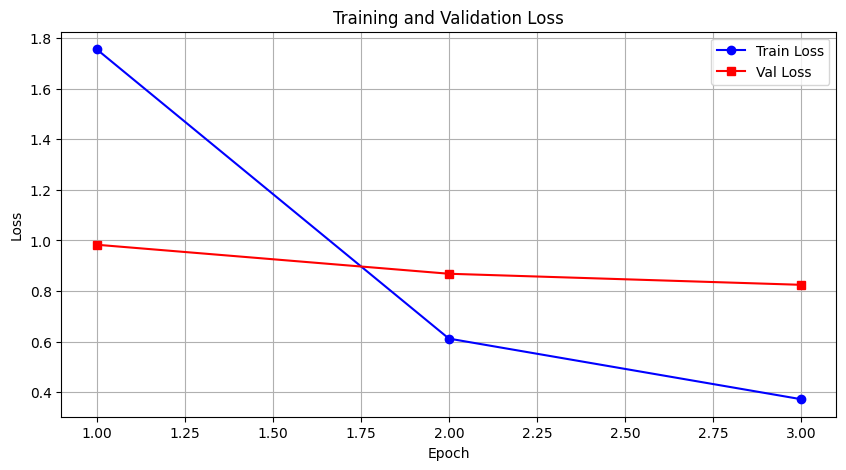

In [8]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Save the fine-tuned model
output_dir = "fine_tuned_vqg_model"
model.save_pretrained(output_dir)
processor.save_pretrained(output_dir)
print(f" Model saved to {output_dir}")


 Model saved to fine_tuned_vqg_model


In [10]:
# Test the fine-tuned model on sample images
def generate_question(model, processor, image_path, bbox=None, device='cuda'):
    """Generate a question for an image (optionally cropped to bbox)"""
    model.eval()
    
    # Load and optionally crop image
    image = Image.open(image_path).convert('RGB')
    if bbox:
        xtl, ytl = int(bbox['xtl']), int(bbox['ytl'])
        xbr, ybr = int(bbox['xbr']), int(bbox['ybr'])
        xtl = max(0, min(xtl, image.width))
        ytl = max(0, min(ytl, image.height))
        xbr = max(xtl, min(xbr, image.width))
        ybr = max(ytl, min(ybr, image.height))
        if xbr > xtl and ybr > ytl:
            image = image.crop((xtl, ytl, xbr, ybr))
    
    # Process and generate
    inputs = processor(images=image, return_tensors="pt").to(device)
    
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_length=50,
            num_beams=5,
            early_stopping=True
        )
    
    generated_text = processor.decode(generated_ids[0], skip_special_tokens=True)
    return generated_text

# Test on a few validation samples
print("\n" + "="*50)
print("Testing Fine-tuned Model")
print("="*50)

model.eval()
test_samples = val_anns[:5]  # Test on first 5 validation samples

for i, sample in enumerate(test_samples):
    print(f"\n--- Sample {i+1} ---")
    print(f"Image: {sample['image_name']}")
    print(f"Domain: {sample['domain']}")
    print(f"Human Question: {sample['question']}")
    print(f"Question Type: {sample['question_type']}")
    print(f"Curiosity Score: {sample['curiosity_score']}/5")
    
    # Generate question
    generated_q = generate_question(
        model, processor, 
        sample['image_path'], 
        bbox=sample['bbox'],
        device=device
    )
    print(f"Generated Question: {generated_q}")
    print("-" * 50)



Testing Fine-tuned Model

--- Sample 1 ---
Image: img_070.png
Domain: Domain_2_Images
Human Question: what is the dog looking at?
Question Type: what
Curiosity Score: 3.0/5
Generated Question: what is the dog looking at?
--------------------------------------------------

--- Sample 2 ---
Image: img_010.png
Domain: Domain_1_Images
Human Question: why is the shoe there?
Question Type: why
Curiosity Score: 4.0/5
Generated Question: why is the shoe there?
--------------------------------------------------

--- Sample 3 ---
Image: img_006.png
Domain: Domain_1_Images
Human Question: why is the basket there?
Question Type: why
Curiosity Score: 3.0/5
Generated Question: why is the basket there?
--------------------------------------------------

--- Sample 4 ---
Image: img_167.png
Domain: Domain_5_Images
Human Question: how is the rock perfectly balanced?
Question Type: how
Curiosity Score: 5.0/5
Generated Question: why is the potato there?
--------------------------------------------------


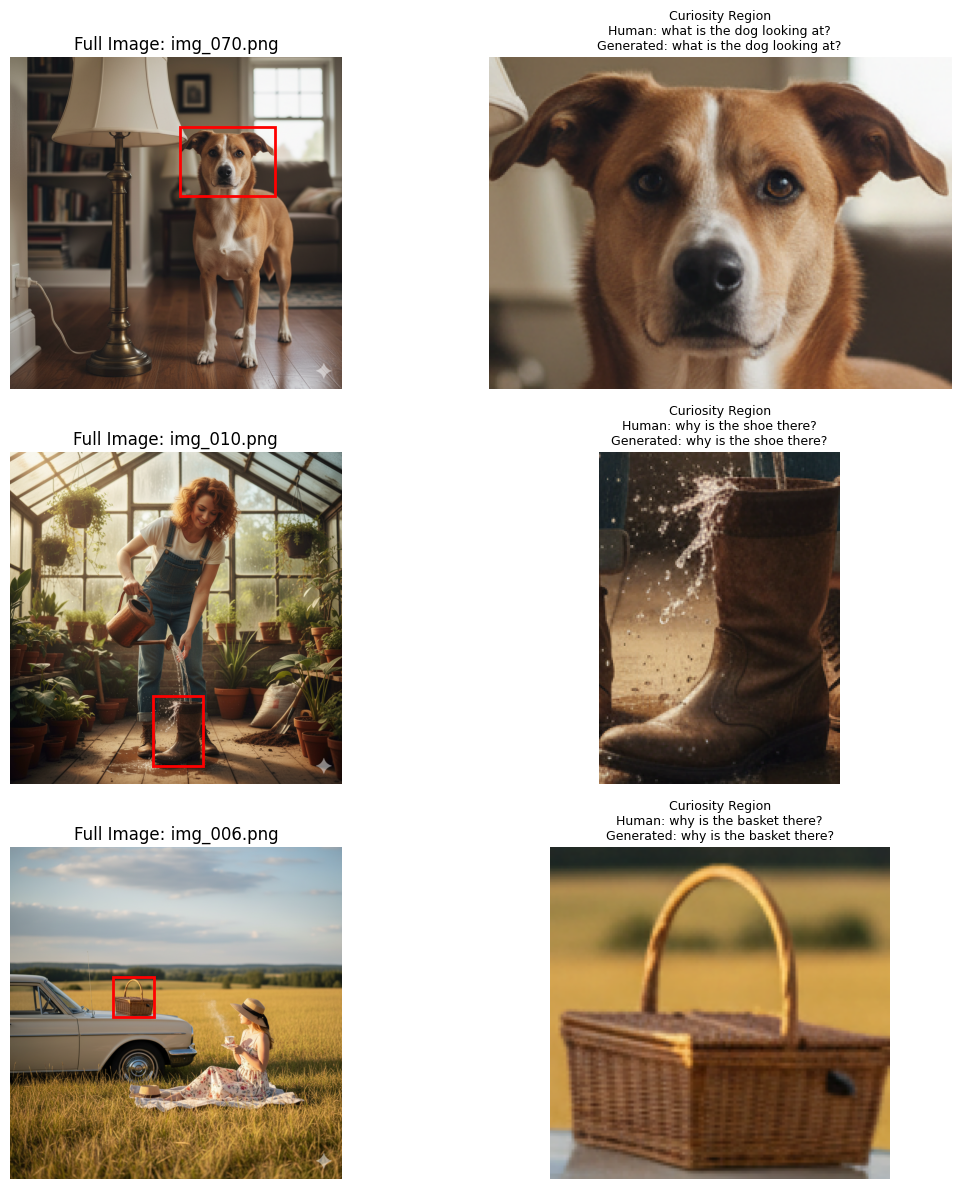

In [11]:
# Visualize some results
def visualize_results(model, processor, samples, device='cuda', num_samples=3):
    """Visualize model predictions vs ground truth"""
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))
    
    for idx, sample in enumerate(samples[:num_samples]):
        # Load image
        img = Image.open(sample['image_path']).convert('RGB')
        bbox = sample['bbox']
        
        # Crop to bbox
        xtl, ytl = int(bbox['xtl']), int(bbox['ytl'])
        xbr, ybr = int(bbox['xbr']), int(bbox['ybr'])
        cropped = img.crop((xtl, ytl, xbr, ybr))
        
        # Generate question
        generated_q = generate_question(model, processor, sample['image_path'], 
                                       bbox=sample['bbox'], device=device)
        
        # Plot full image with bbox
        axes[idx, 0].imshow(img)
        axes[idx, 0].add_patch(plt.Rectangle((xtl, ytl), xbr-xtl, ybr-ytl, 
                                            fill=False, edgecolor='red', linewidth=2))
        axes[idx, 0].set_title(f"Full Image: {sample['image_name']}")
        axes[idx, 0].axis('off')
        
        # Plot cropped region with questions
        axes[idx, 1].imshow(cropped)
        axes[idx, 1].set_title(f"Curiosity Region\nHuman: {sample['question']}\nGenerated: {generated_q}", 
                             fontsize=9)
        axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_results(model, processor, val_anns[:3], device=device)
